In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle


from tensorflow.keras.layers import MultiHeadAttention,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate
from tensorflow.keras import callbacks 

from sklearn.model_selection import KFold

In [2]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6

# get spatial dimension
fname = "D:\\Code\\Fiona\\climate project\\New Data\\profiles/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

In [3]:
# spatial slicing dimensions
os = 82 # output slice size
ts = os # input slice size 32


In [4]:
#get the averaged reflectance from the dataset 
fname_r = "data_reflectance.h5"
hf_r = h5py.File(fname_r, 'r')
r=hf_r['dataset_reflectance']
r.shape


(4000, 82)

In [5]:
#get the averaged reflectance from the dataset 
fname_c = "data_cot.h5"
hf_c = h5py.File(fname_c, 'r')
c=hf_c['dataset_cot']
c.shape

(4000, 82)

In [6]:
c=c[:]
r=r[:]

In [7]:
r,c= shuffle(r, c, random_state=1)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')


train_size: 3200 profiles
test_size: 800 profiles


In [27]:

def eval_model(train_image, test_image, train_label, test_label):

    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()

    bsize = 16
    eps = 4000

    #LSTM
    input_layer = tf.keras.layers.Input(shape=(ts,1),name='Input')
    lstm=tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True,input_shape=(ts,1))(input_layer)
    lstm1=tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True)(lstm)
    lstm2=tf.keras.layers.LSTM(units=96, activation='tanh',return_sequences = True)(lstm1)


    #transformer block 
    slf_attn = MultiHeadAttention(num_heads=3,key_dim=3)(lstm2,lstm2) ####understand the key_dim and num_heads
    layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(slf_attn+lstm2)
    dense1=tf.keras.layers.Dense(96,activation='relu')(layernorm1)
    layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(layernorm1+dense1)
    
    flat=tf.keras.layers.Flatten()(layernorm2)
    #pooling
    #avg_pool = GlobalAveragePooling1D()(layernorm2)
    #max_pool = GlobalMaxPooling1D()(layernorm2)
    #conc = concatenate([avg_pool, max_pool])

    #dense
    #dense2 = tf.keras.layers.Dense(256,activation='relu')(conc)
    drop=tf.keras.layers.Dropout(0.2)(flat)
    output = tf.keras.layers.Dense(os,activation='relu')(drop)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',loss=['mse'],metrics=[ltype,type2])
    model.summary()

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    results
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]
    
    return model,rmse,mse,history,predictions

In [28]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,800*4,ts)) #train: 800*4  test:800
y_train=np.zeros((5,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index] #r: radiance dataset
    y_train[count], y_test[count] = c[train_index], c[test_index] #c: cot dataset(label)
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 800  801  802 ... 3997 3998 3999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [29]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 82, 1)]      0                                            
__________________________________________________________________________________________________
lstm_18 (LSTM)                  (None, 82, 64)       16896       Input[0][0]                      
__________________________________________________________________________________________________
lstm_19 (LSTM)                  (None, 82, 64)       33024       lstm_18[0][0]                    
__________________________________________________________________________________________________
lstm_20 (LSTM)                  (None, 82, 96)       61824       lstm_19[0][0]                    
____________________________________________________________________________________________

175/175 [==============================] - 3s 18ms/step - loss: 0.7000 - mean_squared_error: 0.7000 - root_mean_squared_error: 0.8367 - val_loss: 0.5872 - val_mean_squared_error: 0.5872 - val_root_mean_squared_error: 0.7663
Epoch 56/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.7014 - mean_squared_error: 0.7014 - root_mean_squared_error: 0.8375 - val_loss: 0.5680 - val_mean_squared_error: 0.5680 - val_root_mean_squared_error: 0.7536
Epoch 57/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.6761 - mean_squared_error: 0.6761 - root_mean_squared_error: 0.8222 - val_loss: 0.5547 - val_mean_squared_error: 0.5547 - val_root_mean_squared_error: 0.7448
Epoch 58/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.6765 - mean_squared_error: 0.6765 - root_mean_squared_error: 0.8225 - val_loss: 0.5085 - val_mean_squared_error: 0.5085 - val_root_mean_squared_error: 0.7131
Epoch 59/4000
175/175 [==============================] - 3s 18

175/175 [==============================] - 3s 18ms/step - loss: 0.5201 - mean_squared_error: 0.5201 - root_mean_squared_error: 0.7211 - val_loss: 0.4480 - val_mean_squared_error: 0.4480 - val_root_mean_squared_error: 0.6693
Epoch 124/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.5294 - mean_squared_error: 0.5294 - root_mean_squared_error: 0.7276 - val_loss: 0.4375 - val_mean_squared_error: 0.4375 - val_root_mean_squared_error: 0.6614
Epoch 125/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.5229 - mean_squared_error: 0.5229 - root_mean_squared_error: 0.7231 - val_loss: 0.4356 - val_mean_squared_error: 0.4356 - val_root_mean_squared_error: 0.6600
Epoch 126/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.5220 - mean_squared_error: 0.5220 - root_mean_squared_error: 0.7225 - val_loss: 0.4252 - val_mean_squared_error: 0.4252 - val_root_mean_squared_error: 0.6521
Epoch 127/4000
175/175 [==============================] - 3

175/175 [==============================] - 3s 18ms/step - loss: 0.4506 - mean_squared_error: 0.4506 - root_mean_squared_error: 0.6712 - val_loss: 0.3801 - val_mean_squared_error: 0.3801 - val_root_mean_squared_error: 0.6165
Epoch 192/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4438 - mean_squared_error: 0.4438 - root_mean_squared_error: 0.6662 - val_loss: 0.3695 - val_mean_squared_error: 0.3695 - val_root_mean_squared_error: 0.6078
Epoch 193/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4405 - mean_squared_error: 0.4405 - root_mean_squared_error: 0.6637 - val_loss: 0.3708 - val_mean_squared_error: 0.3708 - val_root_mean_squared_error: 0.6089
Epoch 194/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4416 - mean_squared_error: 0.4416 - root_mean_squared_error: 0.6645 - val_loss: 0.3727 - val_mean_squared_error: 0.3727 - val_root_mean_squared_error: 0.6105
Epoch 195/4000
175/175 [==============================] - 3

Epoch 259/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4058 - mean_squared_error: 0.4058 - root_mean_squared_error: 0.6370 - val_loss: 0.3420 - val_mean_squared_error: 0.3420 - val_root_mean_squared_error: 0.5848
Epoch 260/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4162 - mean_squared_error: 0.4162 - root_mean_squared_error: 0.6451 - val_loss: 0.3318 - val_mean_squared_error: 0.3318 - val_root_mean_squared_error: 0.5760
Epoch 261/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.3995 - mean_squared_error: 0.3995 - root_mean_squared_error: 0.6320 - val_loss: 0.3469 - val_mean_squared_error: 0.3469 - val_root_mean_squared_error: 0.5890
Epoch 262/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4001 - mean_squared_error: 0.4001 - root_mean_squared_error: 0.6325 - val_loss: 0.3342 - val_mean_squared_error: 0.3342 - val_root_mean_squared_error: 0.5781
Epoch 263/4000
175/175 [====================

175/175 [==============================] - 3s 18ms/step - loss: 0.3783 - mean_squared_error: 0.3783 - root_mean_squared_error: 0.6150 - val_loss: 0.3399 - val_mean_squared_error: 0.3399 - val_root_mean_squared_error: 0.5830
Epoch 328/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.3813 - mean_squared_error: 0.3813 - root_mean_squared_error: 0.6175 - val_loss: 0.3253 - val_mean_squared_error: 0.3253 - val_root_mean_squared_error: 0.5704
Epoch 329/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.3777 - mean_squared_error: 0.3777 - root_mean_squared_error: 0.6146 - val_loss: 0.3489 - val_mean_squared_error: 0.3489 - val_root_mean_squared_error: 0.5907
Epoch 330/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.3710 - mean_squared_error: 0.3710 - root_mean_squared_error: 0.6091 - val_loss: 0.3200 - val_mean_squared_error: 0.3200 - val_root_mean_squared_error: 0.5657
Epoch 331/4000
175/175 [==============================] - 3

175/175 [==============================] - 9s 26ms/step - loss: 65.1958 - mean_squared_error: 65.1958 - root_mean_squared_error: 7.9002 - val_loss: 18.8815 - val_mean_squared_error: 18.8815 - val_root_mean_squared_error: 4.3453
Epoch 2/4000
175/175 [==============================] - 3s 18ms/step - loss: 17.5501 - mean_squared_error: 17.5501 - root_mean_squared_error: 4.1872 - val_loss: 12.2953 - val_mean_squared_error: 12.2953 - val_root_mean_squared_error: 3.5065
Epoch 3/4000
175/175 [==============================] - 3s 18ms/step - loss: 11.9648 - mean_squared_error: 11.9648 - root_mean_squared_error: 3.4586 - val_loss: 9.6978 - val_mean_squared_error: 9.6978 - val_root_mean_squared_error: 3.1141
Epoch 4/4000
175/175 [==============================] - 3s 18ms/step - loss: 9.3001 - mean_squared_error: 9.3001 - root_mean_squared_error: 3.0491 - val_loss: 7.1349 - val_mean_squared_error: 7.1349 - val_root_mean_squared_error: 2.6711
Epoch 5/4000
175/175 [==============================] -

175/175 [==============================] - 3s 18ms/step - loss: 0.6180 - mean_squared_error: 0.6180 - root_mean_squared_error: 0.7861 - val_loss: 0.5876 - val_mean_squared_error: 0.5876 - val_root_mean_squared_error: 0.7665
Epoch 70/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.6278 - mean_squared_error: 0.6278 - root_mean_squared_error: 0.7924 - val_loss: 0.4761 - val_mean_squared_error: 0.4761 - val_root_mean_squared_error: 0.6900
Epoch 71/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.6025 - mean_squared_error: 0.6025 - root_mean_squared_error: 0.7761 - val_loss: 0.4787 - val_mean_squared_error: 0.4787 - val_root_mean_squared_error: 0.6919
Epoch 72/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.6098 - mean_squared_error: 0.6098 - root_mean_squared_error: 0.7809 - val_loss: 0.4865 - val_mean_squared_error: 0.4865 - val_root_mean_squared_error: 0.6975
Epoch 73/4000
175/175 [==============================] - 3s 18

175/175 [==============================] - 3s 18ms/step - loss: 0.5041 - mean_squared_error: 0.5041 - root_mean_squared_error: 0.7100 - val_loss: 0.3903 - val_mean_squared_error: 0.3903 - val_root_mean_squared_error: 0.6247
Epoch 138/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4780 - mean_squared_error: 0.4780 - root_mean_squared_error: 0.6914 - val_loss: 0.4178 - val_mean_squared_error: 0.4178 - val_root_mean_squared_error: 0.6463
Epoch 139/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4828 - mean_squared_error: 0.4828 - root_mean_squared_error: 0.6948 - val_loss: 0.4142 - val_mean_squared_error: 0.4142 - val_root_mean_squared_error: 0.6435
Epoch 140/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4804 - mean_squared_error: 0.4804 - root_mean_squared_error: 0.6931 - val_loss: 0.3879 - val_mean_squared_error: 0.3879 - val_root_mean_squared_error: 0.6228
Epoch 141/4000
175/175 [==============================] - 3

175/175 [==============================] - 3s 18ms/step - loss: 0.4262 - mean_squared_error: 0.4262 - root_mean_squared_error: 0.6528 - val_loss: 0.3526 - val_mean_squared_error: 0.3526 - val_root_mean_squared_error: 0.5938
Epoch 206/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4398 - mean_squared_error: 0.4398 - root_mean_squared_error: 0.6632 - val_loss: 0.3561 - val_mean_squared_error: 0.3561 - val_root_mean_squared_error: 0.5967
Epoch 207/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4367 - mean_squared_error: 0.4367 - root_mean_squared_error: 0.6608 - val_loss: 0.3438 - val_mean_squared_error: 0.3438 - val_root_mean_squared_error: 0.5864
Epoch 208/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4177 - mean_squared_error: 0.4177 - root_mean_squared_error: 0.6463 - val_loss: 0.3623 - val_mean_squared_error: 0.3623 - val_root_mean_squared_error: 0.6019
Epoch 209/4000
175/175 [==============================] - 3

175/175 [==============================] - 3s 18ms/step - loss: 1.0330 - mean_squared_error: 1.0330 - root_mean_squared_error: 1.0163 - val_loss: 0.8092 - val_mean_squared_error: 0.8092 - val_root_mean_squared_error: 0.8996
Epoch 20/4000
175/175 [==============================] - 3s 18ms/step - loss: 1.0072 - mean_squared_error: 1.0072 - root_mean_squared_error: 1.0036 - val_loss: 0.8213 - val_mean_squared_error: 0.8213 - val_root_mean_squared_error: 0.9063
Epoch 21/4000
175/175 [==============================] - 3s 18ms/step - loss: 1.0163 - mean_squared_error: 1.0163 - root_mean_squared_error: 1.0081 - val_loss: 0.7306 - val_mean_squared_error: 0.7306 - val_root_mean_squared_error: 0.8548
Epoch 22/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.9496 - mean_squared_error: 0.9496 - root_mean_squared_error: 0.9744 - val_loss: 0.8786 - val_mean_squared_error: 0.8786 - val_root_mean_squared_error: 0.9373
Epoch 23/4000
175/175 [==============================] - 3s 18

175/175 [==============================] - 3s 18ms/step - loss: 0.5846 - mean_squared_error: 0.5846 - root_mean_squared_error: 0.7645 - val_loss: 0.4584 - val_mean_squared_error: 0.4584 - val_root_mean_squared_error: 0.6771
Epoch 88/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.5887 - mean_squared_error: 0.5887 - root_mean_squared_error: 0.7672 - val_loss: 0.4623 - val_mean_squared_error: 0.4623 - val_root_mean_squared_error: 0.6799
Epoch 89/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.5734 - mean_squared_error: 0.5734 - root_mean_squared_error: 0.7571 - val_loss: 0.4995 - val_mean_squared_error: 0.4995 - val_root_mean_squared_error: 0.7068
Epoch 90/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.5973 - mean_squared_error: 0.5973 - root_mean_squared_error: 0.7729 - val_loss: 0.4808 - val_mean_squared_error: 0.4808 - val_root_mean_squared_error: 0.6934
Epoch 91/4000
175/175 [==============================] - 3s 18

175/175 [==============================] - 3s 18ms/step - loss: 0.4770 - mean_squared_error: 0.4770 - root_mean_squared_error: 0.6906 - val_loss: 0.4108 - val_mean_squared_error: 0.4108 - val_root_mean_squared_error: 0.6409
Epoch 156/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4737 - mean_squared_error: 0.4737 - root_mean_squared_error: 0.6882 - val_loss: 0.4589 - val_mean_squared_error: 0.4589 - val_root_mean_squared_error: 0.6774
Epoch 157/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4801 - mean_squared_error: 0.4801 - root_mean_squared_error: 0.6929 - val_loss: 0.4022 - val_mean_squared_error: 0.4022 - val_root_mean_squared_error: 0.6342
Epoch 158/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4680 - mean_squared_error: 0.4680 - root_mean_squared_error: 0.6841 - val_loss: 0.3947 - val_mean_squared_error: 0.3947 - val_root_mean_squared_error: 0.6282
Epoch 159/4000
175/175 [==============================] - 3

175/175 [==============================] - 3s 18ms/step - loss: 0.4144 - mean_squared_error: 0.4144 - root_mean_squared_error: 0.6437 - val_loss: 0.3575 - val_mean_squared_error: 0.3575 - val_root_mean_squared_error: 0.5979
Epoch 224/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4123 - mean_squared_error: 0.4123 - root_mean_squared_error: 0.6421 - val_loss: 0.3455 - val_mean_squared_error: 0.3455 - val_root_mean_squared_error: 0.5878
Epoch 225/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4139 - mean_squared_error: 0.4139 - root_mean_squared_error: 0.6433 - val_loss: 0.3600 - val_mean_squared_error: 0.3600 - val_root_mean_squared_error: 0.6000
Epoch 226/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4221 - mean_squared_error: 0.4221 - root_mean_squared_error: 0.6497 - val_loss: 0.3609 - val_mean_squared_error: 0.3609 - val_root_mean_squared_error: 0.6007
Epoch 227/4000
175/175 [==============================] - 3

175/175 [==============================] - 3s 18ms/step - loss: 0.3782 - mean_squared_error: 0.3782 - root_mean_squared_error: 0.6149 - val_loss: 0.3712 - val_mean_squared_error: 0.3712 - val_root_mean_squared_error: 0.6093
Epoch 292/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.3867 - mean_squared_error: 0.3867 - root_mean_squared_error: 0.6218 - val_loss: 0.3526 - val_mean_squared_error: 0.3526 - val_root_mean_squared_error: 0.5938
Epoch 293/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.3911 - mean_squared_error: 0.3911 - root_mean_squared_error: 0.6253 - val_loss: 0.3400 - val_mean_squared_error: 0.3400 - val_root_mean_squared_error: 0.5831
Epoch 294/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.3872 - mean_squared_error: 0.3872 - root_mean_squared_error: 0.6223 - val_loss: 0.3441 - val_mean_squared_error: 0.3441 - val_root_mean_squared_error: 0.5866
Epoch 295/4000
175/175 [==============================] - 3

175/175 [==============================] - 3s 18ms/step - loss: 0.3630 - mean_squared_error: 0.3630 - root_mean_squared_error: 0.6025 - val_loss: 0.3198 - val_mean_squared_error: 0.3198 - val_root_mean_squared_error: 0.5655
Epoch 360/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.3579 - mean_squared_error: 0.3579 - root_mean_squared_error: 0.5982 - val_loss: 0.3150 - val_mean_squared_error: 0.3150 - val_root_mean_squared_error: 0.5612
Epoch 361/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.3536 - mean_squared_error: 0.3536 - root_mean_squared_error: 0.5946 - val_loss: 0.3434 - val_mean_squared_error: 0.3434 - val_root_mean_squared_error: 0.5860
Epoch 362/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.3628 - mean_squared_error: 0.3628 - root_mean_squared_error: 0.6023 - val_loss: 0.3292 - val_mean_squared_error: 0.3292 - val_root_mean_squared_error: 0.5737
Epoch 363/4000
175/175 [==============================] - 3

Epoch 7/4000
175/175 [==============================] - 3s 18ms/step - loss: 5.4791 - mean_squared_error: 5.4791 - root_mean_squared_error: 2.3407 - val_loss: 4.5709 - val_mean_squared_error: 4.5709 - val_root_mean_squared_error: 2.1380
Epoch 8/4000
175/175 [==============================] - 3s 18ms/step - loss: 4.7527 - mean_squared_error: 4.7527 - root_mean_squared_error: 2.1800 - val_loss: 3.9356 - val_mean_squared_error: 3.9356 - val_root_mean_squared_error: 1.9838
Epoch 9/4000
175/175 [==============================] - 3s 18ms/step - loss: 4.0435 - mean_squared_error: 4.0435 - root_mean_squared_error: 2.0108 - val_loss: 3.3326 - val_mean_squared_error: 3.3326 - val_root_mean_squared_error: 1.8255
Epoch 10/4000
175/175 [==============================] - 3s 18ms/step - loss: 3.5497 - mean_squared_error: 3.5497 - root_mean_squared_error: 1.8840 - val_loss: 2.9622 - val_mean_squared_error: 2.9622 - val_root_mean_squared_error: 1.7211
Epoch 11/4000
175/175 [============================

175/175 [==============================] - 3s 18ms/step - loss: 0.6523 - mean_squared_error: 0.6523 - root_mean_squared_error: 0.8076 - val_loss: 0.5430 - val_mean_squared_error: 0.5430 - val_root_mean_squared_error: 0.7369
Epoch 76/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.6257 - mean_squared_error: 0.6257 - root_mean_squared_error: 0.7910 - val_loss: 0.4920 - val_mean_squared_error: 0.4920 - val_root_mean_squared_error: 0.7014
Epoch 77/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.6055 - mean_squared_error: 0.6055 - root_mean_squared_error: 0.7781 - val_loss: 0.5475 - val_mean_squared_error: 0.5475 - val_root_mean_squared_error: 0.7399
Epoch 78/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.6230 - mean_squared_error: 0.6230 - root_mean_squared_error: 0.7893 - val_loss: 0.5498 - val_mean_squared_error: 0.5498 - val_root_mean_squared_error: 0.7415
Epoch 79/4000
175/175 [==============================] - 3s 18

175/175 [==============================] - 3s 18ms/step - loss: 0.4794 - mean_squared_error: 0.4794 - root_mean_squared_error: 0.6923 - val_loss: 0.4117 - val_mean_squared_error: 0.4117 - val_root_mean_squared_error: 0.6416
Epoch 144/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4945 - mean_squared_error: 0.4945 - root_mean_squared_error: 0.7032 - val_loss: 0.4708 - val_mean_squared_error: 0.4708 - val_root_mean_squared_error: 0.6861
Epoch 145/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4851 - mean_squared_error: 0.4851 - root_mean_squared_error: 0.6965 - val_loss: 0.3889 - val_mean_squared_error: 0.3889 - val_root_mean_squared_error: 0.6236
Epoch 146/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4861 - mean_squared_error: 0.4861 - root_mean_squared_error: 0.6972 - val_loss: 0.3807 - val_mean_squared_error: 0.3807 - val_root_mean_squared_error: 0.6170
Epoch 147/4000
175/175 [==============================] - 3

25/25 [==============================] - 1s 8ms/step - loss: 0.3349 - mean_squared_error: 0.3349 - root_mean_squared_error: 0.5787
MSE on test set in fold4 : 0.3349064588546753
RMSE on test set in fold4 : 0.5787110328674316
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 82, 1)]      0                                            
__________________________________________________________________________________________________
lstm_30 (LSTM)                  (None, 82, 64)       16896       Input[0][0]                      
__________________________________________________________________________________________________
lstm_31 (LSTM)                  (None, 82, 64)       33024       lstm_30[0][0]                    
__________________________________________________________________

175/175 [==============================] - 3s 18ms/step - loss: 0.6787 - mean_squared_error: 0.6787 - root_mean_squared_error: 0.8238 - val_loss: 0.5306 - val_mean_squared_error: 0.5306 - val_root_mean_squared_error: 0.7284
Epoch 55/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.6696 - mean_squared_error: 0.6696 - root_mean_squared_error: 0.8183 - val_loss: 0.5091 - val_mean_squared_error: 0.5091 - val_root_mean_squared_error: 0.7135
Epoch 56/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.6637 - mean_squared_error: 0.6637 - root_mean_squared_error: 0.8146 - val_loss: 0.5204 - val_mean_squared_error: 0.5204 - val_root_mean_squared_error: 0.7214
Epoch 57/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.6779 - mean_squared_error: 0.6779 - root_mean_squared_error: 0.8233 - val_loss: 0.5438 - val_mean_squared_error: 0.5438 - val_root_mean_squared_error: 0.7374
Epoch 58/4000
175/175 [==============================] - 3s 18

175/175 [==============================] - 3s 18ms/step - loss: 0.5065 - mean_squared_error: 0.5065 - root_mean_squared_error: 0.7117 - val_loss: 0.4048 - val_mean_squared_error: 0.4048 - val_root_mean_squared_error: 0.6363
Epoch 123/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.5086 - mean_squared_error: 0.5086 - root_mean_squared_error: 0.7131 - val_loss: 0.4124 - val_mean_squared_error: 0.4124 - val_root_mean_squared_error: 0.6422
Epoch 124/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.5109 - mean_squared_error: 0.5109 - root_mean_squared_error: 0.7147 - val_loss: 0.4179 - val_mean_squared_error: 0.4179 - val_root_mean_squared_error: 0.6464
Epoch 125/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.5142 - mean_squared_error: 0.5142 - root_mean_squared_error: 0.7171 - val_loss: 0.4080 - val_mean_squared_error: 0.4080 - val_root_mean_squared_error: 0.6387
Epoch 126/4000
175/175 [==============================] - 3

175/175 [==============================] - 3s 18ms/step - loss: 0.4457 - mean_squared_error: 0.4457 - root_mean_squared_error: 0.6676 - val_loss: 0.3825 - val_mean_squared_error: 0.3825 - val_root_mean_squared_error: 0.6185
Epoch 191/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4431 - mean_squared_error: 0.4431 - root_mean_squared_error: 0.6656 - val_loss: 0.3906 - val_mean_squared_error: 0.3906 - val_root_mean_squared_error: 0.6250
Epoch 192/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4492 - mean_squared_error: 0.4492 - root_mean_squared_error: 0.6702 - val_loss: 0.3617 - val_mean_squared_error: 0.3617 - val_root_mean_squared_error: 0.6014
Epoch 193/4000
175/175 [==============================] - 3s 18ms/step - loss: 0.4371 - mean_squared_error: 0.4371 - root_mean_squared_error: 0.6611 - val_loss: 0.3522 - val_mean_squared_error: 0.3522 - val_root_mean_squared_error: 0.5934
Epoch 194/4000
175/175 [==============================] - 3

In [30]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 0.3231 with standard deviation (0.0081)
Estimated RMSE 0.5683 with standard deviation (0.0071)


In [31]:
cv_scores

[0.3101750314235687,
 0.323953241109848,
 0.3198409974575043,
 0.3349064588546753,
 0.32647812366485596]

In [32]:
cv_scores2

[0.556933581829071,
 0.5691689252853394,
 0.5655447840690613,
 0.5787110328674316,
 0.5713826417922974]

In [33]:
predictions.shape

(800, 82)

In [34]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


The optimal number of epochs is 229


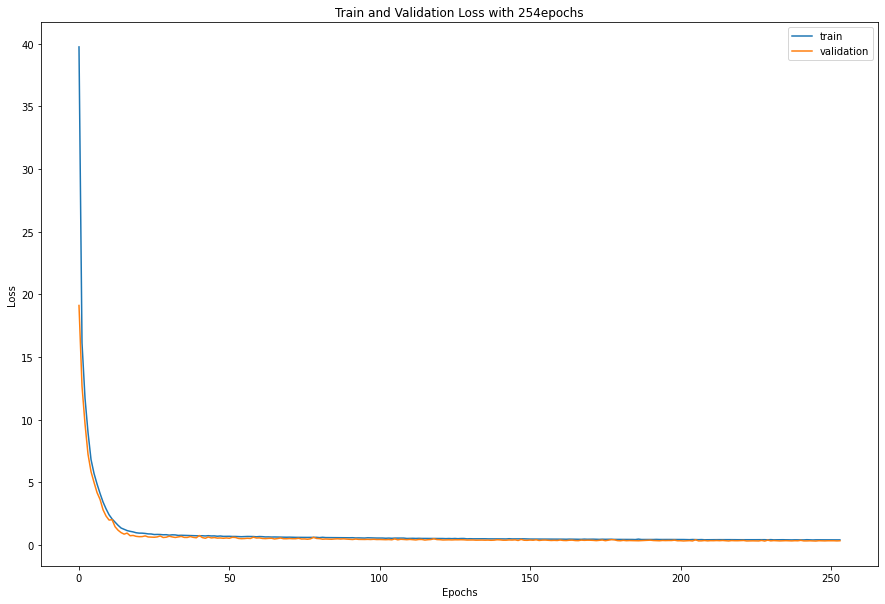

In [35]:
patience=25
# plotting training and validation history
plt.figure(figsize=(15,10))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 


plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 

plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [36]:
predictions.shape

(800, 82)

In [37]:
predict1=np.zeros(os) 
predict1=predictions[-3]
    
predict2=np.zeros((os))
predict2=predictions[-2]
    
predict3=np.zeros((os))
predict3=predictions[-1]

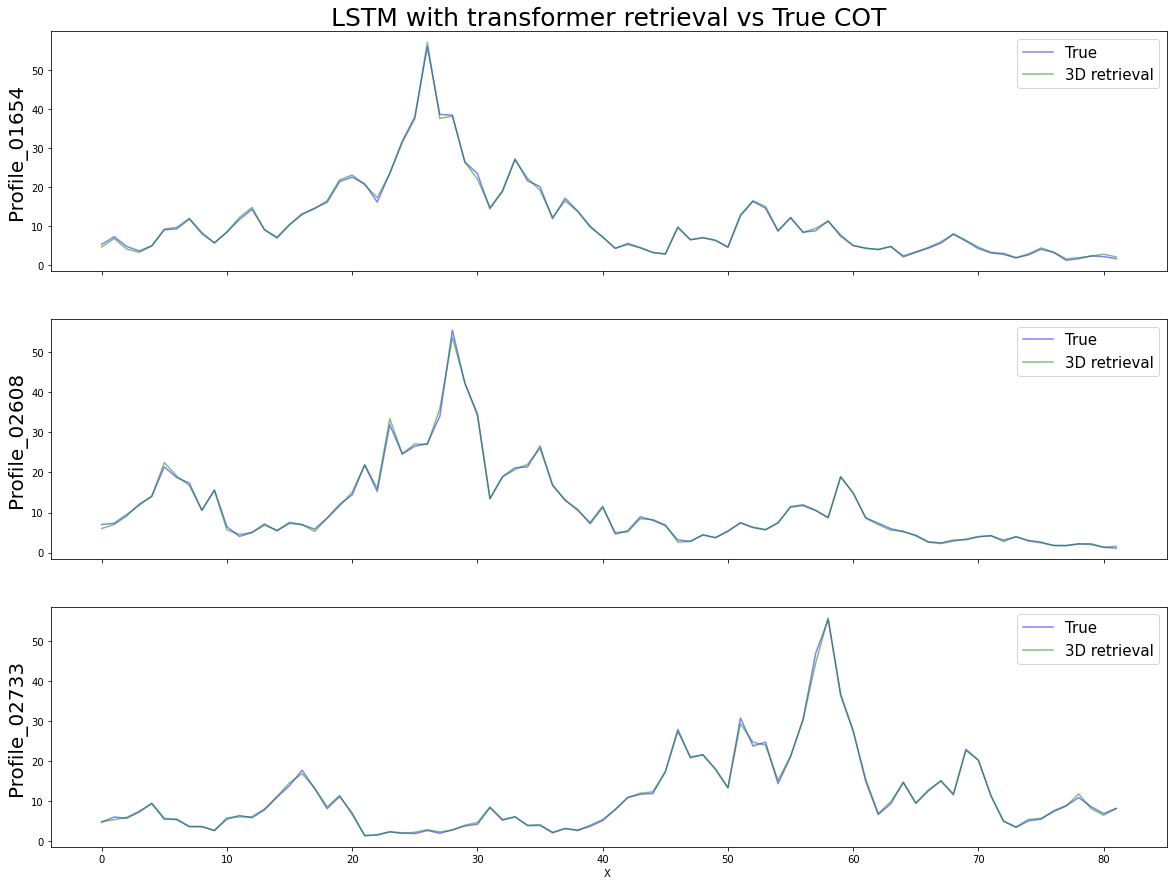

In [41]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict_LSTM with Transformer SZA=60 VZA=0_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"LSTM with transformer retrieval vs True COT",fontsize=25)
ax.plot(range(82),test_label[800-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "3D retrieval",'1D retrieval'],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),test_label[800-2,:],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "3D retrieval",'1D retrieval'],fontsize=15)
ax.set_ylabel(r"Profile_02608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),test_label[800-1,:].T,alpha=0.5,color="blue")
ax.plot(range(82),predict3.reshape(82,),alpha=0.5,color="green")
ax.legend(["True", "3D retrieval",'1D retrieval'],fontsize=15)
ax.set_ylabel(r"Profile_02733",fontsize=20)  
ax.set_xlabel('X ')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')



# Plotting across predicted 82 COT values

In [40]:
std=[]
mean=[]

for k in range(os):
    tmp=[]
    for j in range(800):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))
    std.append(np.std(tmp))
    mean.append(np.mean(tmp))

std=np.array(std)
mean=np.array(mean)

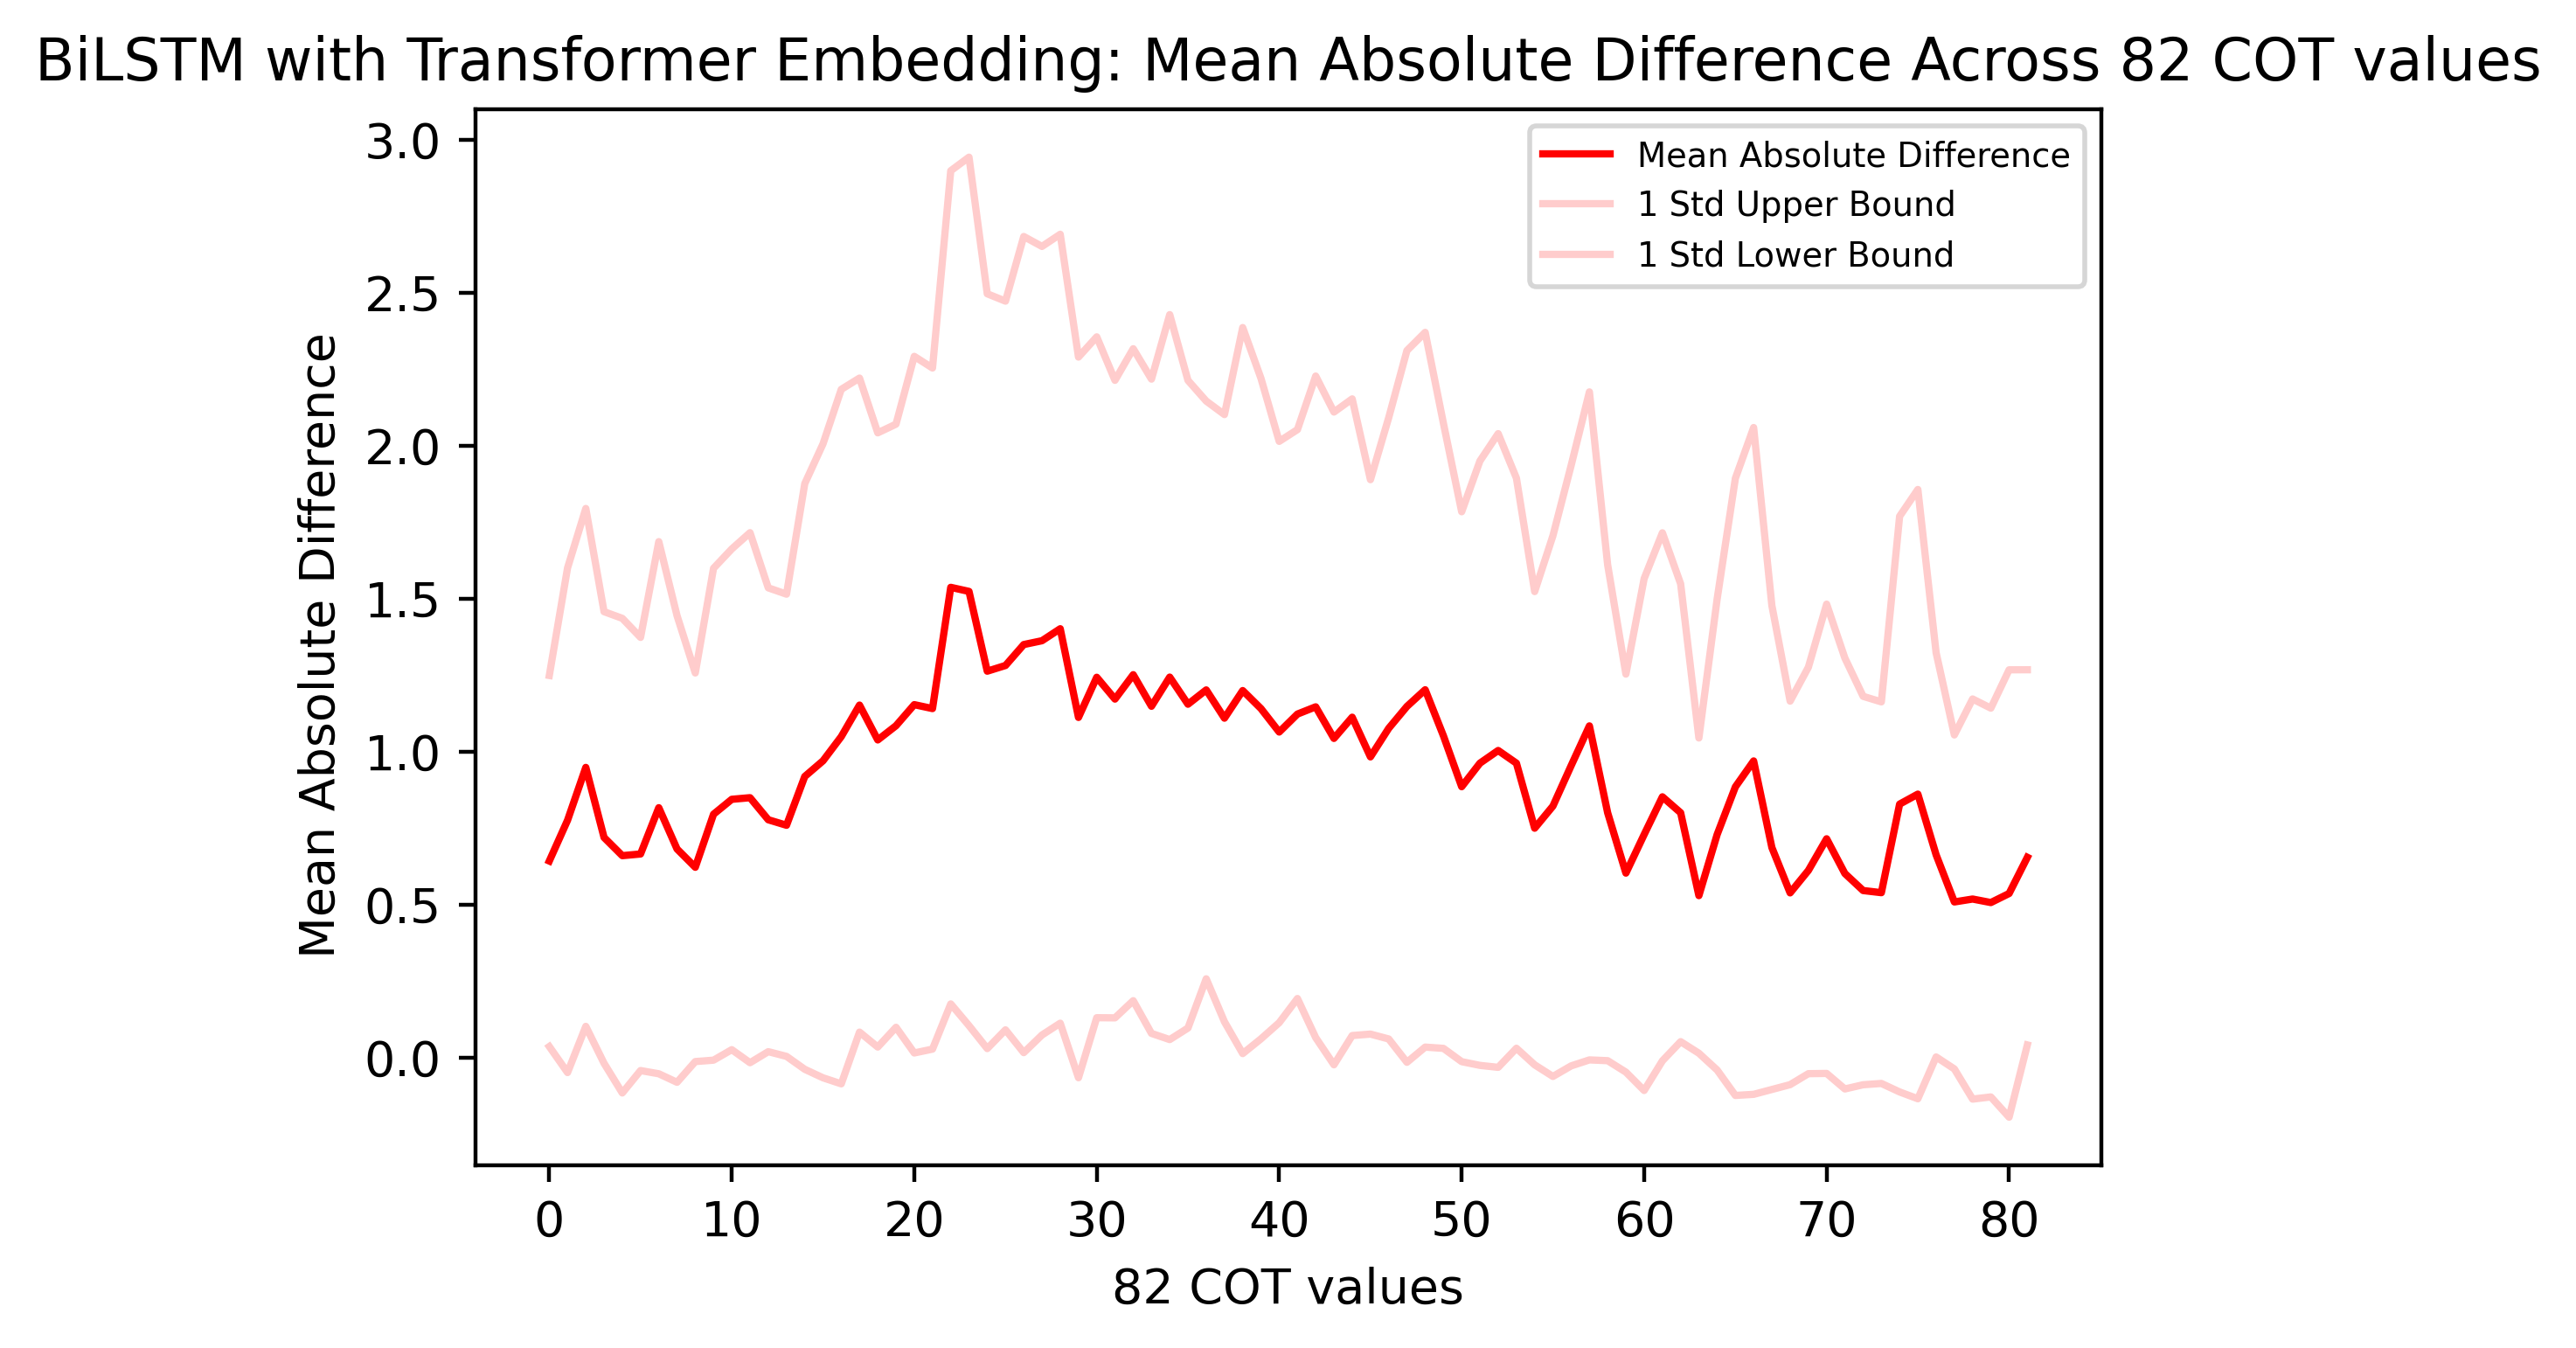

In [41]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM with Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM-transformer_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)